# Exoplanet minimization fitting with `batman`

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from lightkurve import KeplerTargetPixelFile
import numpy as np
import matplotlib.pyplot as plt
from lightkurve.injection import TransitModel
import lightkurve.injection as inj
import scipy.optimize as op
import batman

In [2]:
tpf_star = KeplerTargetPixelFile.from_archive(1867630, quarter=1)
lc_star = tpf_star.to_lightcurve(aperture_mask='all')

Normalize the initial lightcurve and inject a normalized lc into that:

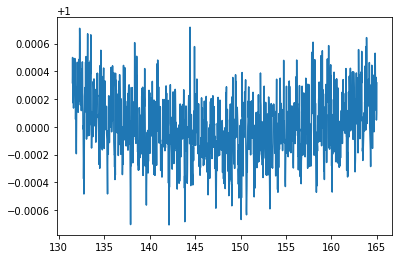

In [45]:
#Remove nans and outliers
lc_star = lc_star.remove_nans().remove_outliers()

lc_star = lc_star.normalize()
plt.plot(lc_star.time, lc_star.flux)

Create transit model using batman:

In [46]:
params = batman.TransitParams()       #object to store transit parameters
params.t0 = 133                      #time of inferior conjunction
params.per = 5.                       #orbital period
params.rp = 0.15                     #planet radius (in units of stellar radii)
params.a = 15.                        #semi-major axis (in units of stellar radii)
params.inc = 90.                      #orbital inclination (in degrees)
params.ecc = 0.                       #eccentricity
params.w = 90.                        #longitude of periastron (in degrees)
params.limb_dark = "nonlinear"        #limb darkening model
params.u = [0.5, 0.1, 0.1, -0.1]      #limb darkening coefficients [u1, u2, u3, u4]

t = lc_star.time.astype(np.float)  #times at which to calculate light curve
m = batman.TransitModel(params, t)    #initializes model
flux = m.light_curve(params)   

This is the transit model to be added to the Kepler LC:

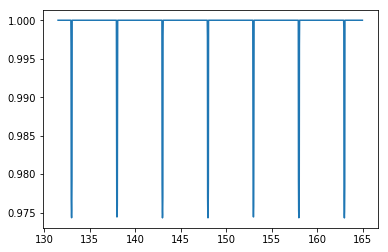

In [47]:
plt.plot(t, flux)

In [48]:
lcinj_time = lc_star.time
lcinj_flux = lc_star.flux * flux
lcinj_fluxerr = lc_star.flux_err

np.min(lcinj_time)

131.51266101733199

This is the injected light curve (not a SyntheticLightCurve class -- hopefully things will still work the same)

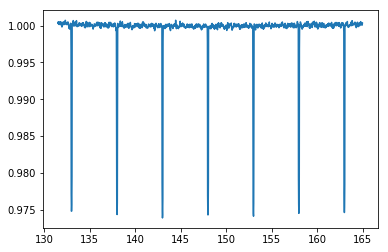

In [49]:
plt.plot(lcinj_time, lcinj_flux)

# BLS Search

Before optimizing, let's do a BLS search to get an approximation for our optimization initial guess.

In [50]:
from astropy.stats import BLS

In [51]:
model = BLS(lcinj_time, lcinj_flux, dy=0.01)

In [52]:
periodogram = model.autopower(0.2)

55.180243924


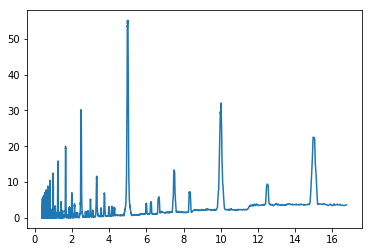

In [53]:
plt.plot(periodogram.period, periodogram.power)
print(np.max(periodogram.power))

In [54]:
best_index = np.argmax(periodogram.power)

In [55]:
bls_period = periodogram.period[best_index]
print(bls_period)

5.00429046195


In [56]:
depth = periodogram.depth[best_index]
bls_rprs = np.sqrt(depth)
print(bls_rprs)

0.113288206715


depth_err = periodogram.depth_err[best_index]
print(depth_err)
max_depth = depth + depth_err
np.sqrt(max_depth)

In [57]:
phase = periodogram.transit_time[best_index]
#phase = periodogram.transit_time[best_index]/bls_period
print(phase)
#phase = phase+np.min(lcinj_time)
#print(phase)
print(np.mod(133.,7.))
print((7-6.84)*24*60)

2.84
0.0
230.4000000000002


# Optimization

Now let's try to recover this using scipy.optimize.minimize.

In [58]:
import scipy.optimize as op

In [59]:
def ln_like(theta):
    period, rprs, T0 = theta
    
    params = batman.TransitParams()       #object to store transit parameters
    params.t0 = T0                        #time of inferior conjunction
    params.per = period                   #orbital period
    params.rp = rprs                      #planet radius (in units of stellar radii)
    params.a = 15.                        #semi-major axis (in units of stellar radii)
    params.inc = 90.                      #orbital inclination (in degrees)
    params.ecc = 0.                       #eccentricity
    params.w = 90.                        #longitude of periastron (in degrees)
    params.limb_dark = "nonlinear"        #limb darkening model
    params.u = [0.5, 0.1, 0.1, -0.1]      #limb darkening coefficients [u1, u2, u3, u4]
    
    t = lc_star.time.astype(np.float)
    m = batman.TransitModel(params, t, fac=1.0)
    flux = m.light_curve(params) 
    
    inv_sigma2 = 1.0/(lcinj_fluxerr**2)
    chisq = (np.sum((lcinj_flux - flux)**2 * inv_sigma2))
    lnlikelihood = -0.5*chisq
    
    return lnlikelihood

In [60]:
def neg_ln_posterior(theta):
    return -ln_like(theta)

In [61]:
%%time

x0 = [bls_period, bls_rprs, phase]
print(x0)
result = op.minimize(neg_ln_posterior, x0)

[5.0042904619459421, 0.11328820671488295, 2.8400000000000003]
CPU times: user 171 ms, sys: 1.47 ms, total: 172 ms
Wall time: 172 ms


In [62]:
print(result)
period_f, rprs_f, T0_f = result.x

      fun: 4129.96307823822
 hess_inv: array([[  1.28741048e-10,   1.89011991e-10,  -3.65446097e-09],
       [  1.89011991e-10,   4.91259756e-09,  -5.08642075e-09],
       [ -3.65446097e-09,  -5.08642075e-09,   1.04268284e-07]])
      jac: array([-443798.16278076,  -11387.70550537,  -20655.20953369])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 577
      nit: 9
     njev: 113
   status: 2
  success: False
        x: array([ 5.0000029 ,  0.1493162 ,  2.99996447])


In [63]:
params = batman.TransitParams()       #object to store transit parameters
params.t0 = T0_f                   #time of inferior conjunction
params.per = period_f                      #orbital period
params.rp = rprs_f                    #planet radius (in units of stellar radii)
params.a = 15.                        #semi-major axis (in units of stellar radii)
params.inc = 90.                      #orbital inclination (in degrees)
params.ecc = 0.                       #eccentricity
params.w = 90.                        #longitude of periastron (in degrees)
params.limb_dark = "nonlinear"        #limb darkening model
params.u = [0.5, 0.1, 0.1, -0.1]      #limb darkening coefficients [u1, u2, u3, u4]

t = lc_star.time.astype(np.float)  #times at which to calculate light curve
m_fit = batman.TransitModel(params, t, fac=1.0)    #initializes model
flux_fit = m.light_curve(params)

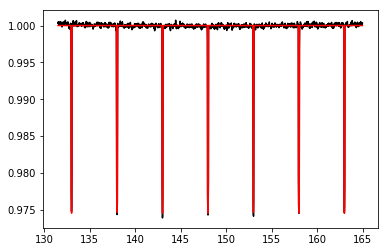

In [64]:
plt.plot(lcinj_time, lcinj_flux, color='k')
plt.plot(t, flux_fit, color='r')

Plot the chi square values over some tested ranges of period, rprs, and T0.  minimize is not finding the minima -- could this be because the plots are not smooth?

In [524]:
rprs_arr = np.linspace(0.01, 0.7, 50)

chisqs = rprs_arr*0.0
for i, rprs in enumerate(rprs_arr):
    chisq = neg_ln_posterior([5, rprs, 133])
    chisqs[i] = chisq

rprs_arr[np.argmin(chisqs)]

0.15081632653061225

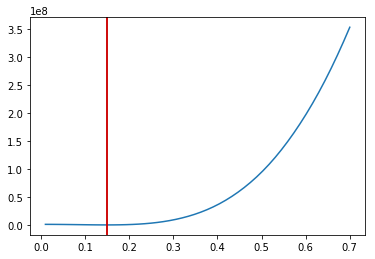

In [525]:
plt.plot(rprs_arr, chisqs)
plt.axvline(0.15, color='k')
plt.axvline(rprs_f, color='r')

In [522]:
per_arr = np.linspace(0, 15, 40)
print(per_arr)

chisqs = per_arr*0.0
for i, per in enumerate(per_arr):
    chisq = neg_ln_posterior([per, 0.3, 133])
    chisqs[i] = chisq

[  0.           0.38461538   0.76923077   1.15384615   1.53846154
   1.92307692   2.30769231   2.69230769   3.07692308   3.46153846
   3.84615385   4.23076923   4.61538462   5.           5.38461538
   5.76923077   6.15384615   6.53846154   6.92307692   7.30769231
   7.69230769   8.07692308   8.46153846   8.84615385   9.23076923
   9.61538462  10.          10.38461538  10.76923077  11.15384615
  11.53846154  11.92307692  12.30769231  12.69230769  13.07692308
  13.46153846  13.84615385  14.23076923  14.61538462  15.        ]


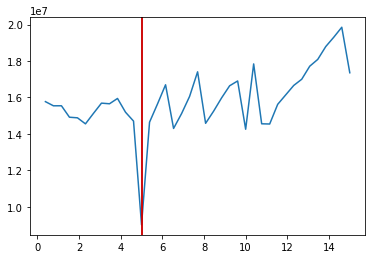

In [523]:
plt.cla()
plt.plot(per_arr, chisqs)
plt.axvline(5, color='k')
plt.axvline(period_f, color='r')

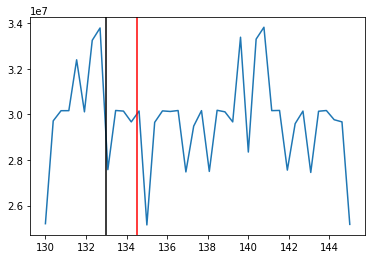

In [476]:
T0_arr = np.linspace(130, 145, 40)

chisqs = T0_arr*0.0
for i, T0 in enumerate(T0_arr):
    chisq = neg_ln_posterior([8, 0.3, T0])
    chisqs[i] = chisq
    
plt.plot(T0_arr, chisqs)
plt.axvline(133, color='k')
plt.axvline(np.min(lcinj_time)+T0_f, color='r')

this plot is not useful ^
